In [53]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt
import cv2

import shutil, os
import splitfolders

In [54]:
target ="./Datasets/DR"
files = os.listdir("./Mild/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy("./Mild/"+file_name, target)

files = os.listdir("./Moderate/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy("./Moderate/"+file_name, target)

files = os.listdir("./Proliferate_DR/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy("./Proliferate_DR/"+file_name, target)

files = os.listdir("./Severe/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy("./Severe/"+file_name, target)


target = "./Datasets/NO_DR/"
files = os.listdir("./No_DR/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy("./No_DR/"+file_name, target)

In [55]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [56]:
walk_through_dir("./Datasets")

There are 2 directories and 0 images in './Datasets'.
There are 0 directories and 1857 images in './Datasets\DR'.
There are 0 directories and 1805 images in './Datasets\No_DR'.


In [57]:
data_path = "./Datasets"

splitfolders.ratio(data_path, output="./Data", seed=42, ratio=(0.8, 0.2))

input_path = "./Data/"

Copying files: 3662 files [00:16, 215.48 files/s]


In [58]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'val', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=1),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=1)  # for Kaggle
}

In [59]:
import pennylane as qml
from pennylane import numpy as np
n_qubits = 4                 # Number of qubits
q_depth = 10                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01               # Initial spread of random quantum weights
start_time = time.time()

In [60]:
dev = qml.device("default.qubit", wires=n_qubits)  # a simple state simulator of qubit-based quantum circuit architectures provided by pennylane

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
torch.cuda

<module 'torch.cuda' from 'c:\\Program Files\\Python39\\lib\\site-packages\\torch\\cuda\\__init__.py'>

In [63]:
device

device(type='cuda', index=0)

In [64]:
def H_layer(nqubits):
    """
      Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """
      Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """
      Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [65]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basisT
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [66]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()

        self.pre_net = nn.Linear(8,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [67]:
from torchvision.models import resnet50, ResNet50_Weights

model1 = torchvision.models.resnet152(pretrained = False, weights = ResNet50_Weights)

model1.fc = nn.Sequential(
    nn.Linear(2048, 512),
    # nn.Linear(1920,512),
    nn.ReLU(inplace = True),
    nn.Linear(512,256),
    nn.ReLU(inplace = True),
    nn.Linear(256,128),
    nn.Linear(128,64),
    nn.ReLU(inplace = True),
    nn.Linear(64,16),
    # nn.Linear(32,16),
    nn.Linear(16,8),
    DressedQuantumNet()
)


model1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [68]:
test_acc , train_acc, test_loss, train_loss = [], [], [], []

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            if(phase == "train"):
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

            else:
                test_acc.append(epoch_acc)
                test_loss.append(epoch_loss)

    return model

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.fc.parameters())

In [70]:
model_trained = train_model(model1, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 0.4688, acc: 0.8129
validation loss: 0.2804, acc: 0.9386
Epoch 2/20
----------
train loss: 0.2872, acc: 0.9194
validation loss: 0.2095, acc: 0.9468
Epoch 3/20
----------
train loss: 0.2464, acc: 0.9245
validation loss: 0.2548, acc: 0.9304
Epoch 4/20
----------
train loss: 0.2248, acc: 0.9266
validation loss: 0.1973, acc: 0.9427
Epoch 5/20
----------
train loss: 0.1786, acc: 0.9464
validation loss: 0.1931, acc: 0.9413
Epoch 6/20
----------
train loss: 0.1781, acc: 0.9437
validation loss: 0.1563, acc: 0.9509
Epoch 7/20
----------
train loss: 0.1803, acc: 0.9447
validation loss: 0.1513, acc: 0.9604
Epoch 8/20
----------
train loss: 0.1966, acc: 0.9310
validation loss: 0.1514, acc: 0.9550
Epoch 9/20
----------
train loss: 0.1799, acc: 0.9389
validation loss: 0.1281, acc: 0.9618
Epoch 10/20
----------
train loss: 0.1624, acc: 0.9495
validation loss: 0.1152, acc: 0.9714
Epoch 11/20
----------
train loss: 0.1723, acc: 0.9437
validation loss: 0.1274, acc: 0.96

In [74]:
te_acc = []

for i in test_acc :
  te_acc.append(i.cpu())

tr_acc = []

for i in train_acc :
  tr_acc.append(i.cpu())


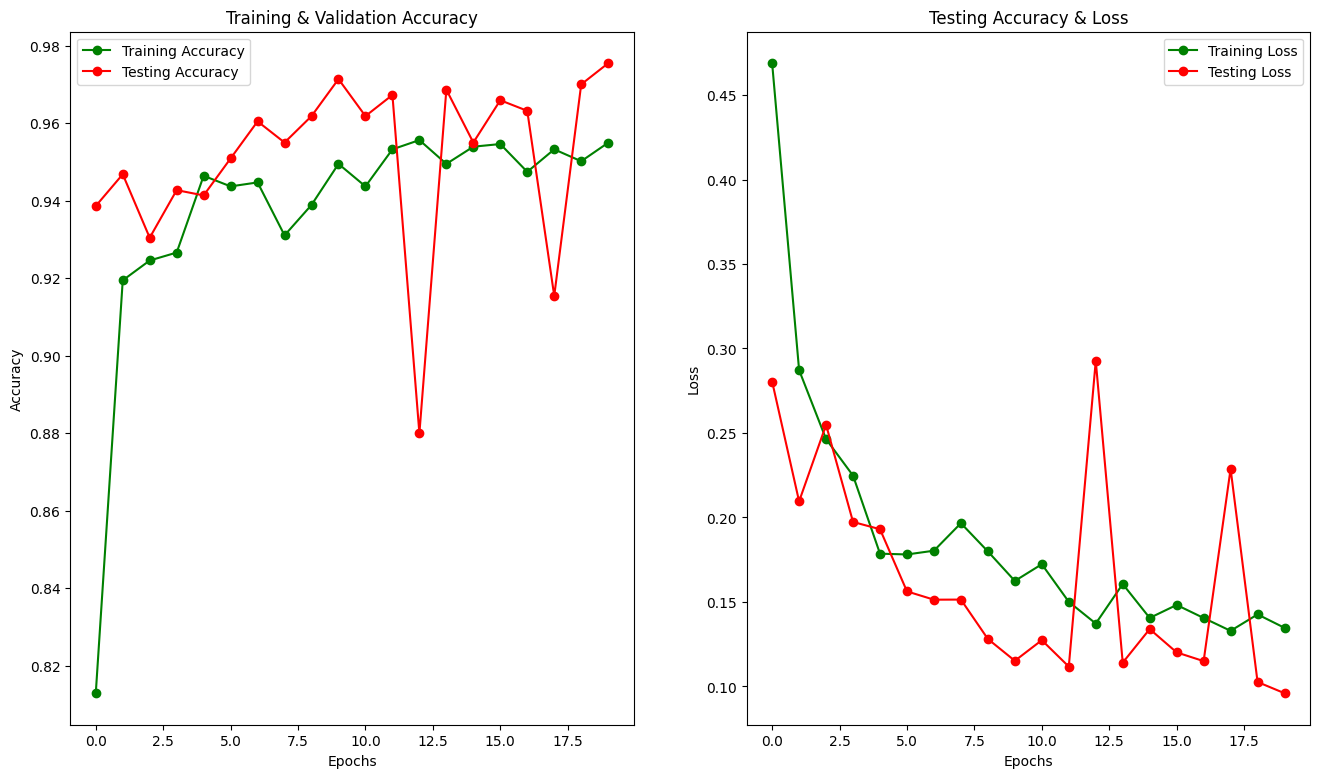

In [75]:
import matplotlib.pyplot as plt
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = tr_acc
train_loss = train_loss
val_acc = te_acc
val_loss = test_loss
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [80]:
torch.save(model_trained.state_dict(),"./mymodel.pt")

In [77]:
phase = "validation"

y_preds = []
label = []

model1.eval()
for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model1(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                y_preds.append(preds.cpu())
                label.append(labels.cpu())

In [78]:
y_pred = np.array(y_preds[0])
y_true = np.array(label[0])

for i in range(1,len(y_preds)):
  y_pred = np.append(y_pred, np.array(y_preds[i]))

for i in range(1,len(label)):
  y_true = np.append(y_true, np.array(label[i]))

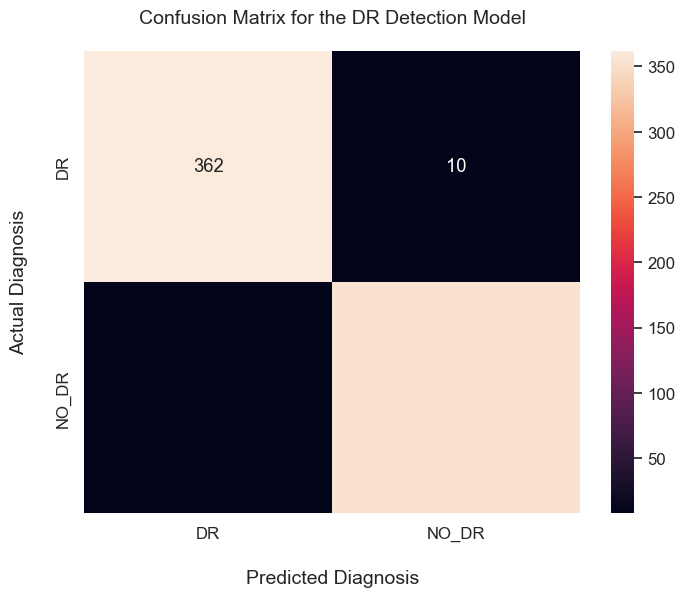

In [79]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)


import seaborn as sns


plt.figure(figsize=(8,6), dpi=100)

sns.set(font_scale = 1.1)

ax = sns.heatmap(cnf, annot=True, fmt='d', )


ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['DR', 'NO_DR'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['DR', 'NO_DR'])

# set plot title
ax.set_title("Confusion Matrix for the DR Detection Model", fontsize=14, pad=20)

plt.show()